In [7]:
from gudhi.datasets.generators import points
from DensiTDA import alphatools, graphtools, landmarktools 
import numpy as np
import gudhi
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import laplacian
from hodgelaplacians import HodgeLaplacians
from gudhi.representations.vector_methods import PersistenceImage
from scipy.spatial.distance import cdist, pdist, squareform
import seaborn as sns
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from collections import defaultdict
import itertools
from tqdm import tqdm
import random
import math

In [8]:
class SimplexTree: 
    
    def __init__(self): 
        
        self.X = [-1, defaultdict(lambda: [ 0.0, defaultdict(list)] ) ]

    def contains_simplex(self, my_tuple): 
        
        curr_level = self.X
        for index in my_tuple: 
            if index in curr_level[1].keys():
                curr_level = curr_level[1][index] 
            else: 
                return False 
            
        return True
    
    def simplex_val(self, my_tuple): 
        
        curr_level = self.X
        for index in my_tuple: 
            if index in curr_level[1].keys():
                curr_level = curr_level[1][index] 
            else: 
                return math.inf 
            
        return curr_level[0]
    
    def simplex_leaves(self, my_tuple): 
        
        curr_level = self.X
        for index in my_tuple: 
            if index in curr_level[1].keys():
                curr_level = curr_level[1][index] 
            else: 
                return [] 
            
        return list(curr_level[1].keys())
    
    def add_simplex(self, new_simplex,val):
    
        curr_level = self.X
        for index in new_simplex[:-1]: 
            if index in curr_level[1].keys():
                curr_level = curr_level[1][index] 
            else: 
                return False 
        
        curr_level[1][new_simplex[-1]] = [ val, defaultdict(lambda: [ 0.0, defaultdict(list)] ) ]
        
        return True
    

def VietorisRips(S, max_dimension = -1, max_radius = 2): 
    
    if max_dimension < 0: 
        max_dimension = len(S[0,:])
    
    R = np.sqrt(max_radius)
    
    VR_complex = defaultdict(list)
    X = SimplexTree()
    
    for i, s in enumerate(S): 
        VR_complex[0].append(([i], 0.0))
        X.add_simplex([i], 0.0)

    print("Evaluating Dimension", 1)
    
    Y = np.zeros((len(S), len(S)))
    adjacency = np.zeros((len(S), len(S)))
    with tqdm(total = len(S) ** 2) as pbar:
        for i in range(len(S)):
            curr_row = []
            for j in range(len(S)): 
                center_distance = np.linalg.norm(S[i] - S[j])
                
                if center_distance < max_radius:
                    VR_complex[1].append(([i,j], center_distance))
                    Y[i,j] = center_distance
                    adjacency[i,j] = 1
                    X.add_simplex([i,j], center_distance)
                else:
                    Y[i,j] = math.inf

                pbar.update(1)
                
    print("\tNumber of Connected Components: ", connected_components(adjacency)[0])

    for curr_dim in range(2,max_dimension + 1):
        
        print("Estimating Number of Facets for dimension ", curr_dim, "Part 1:")
            
        facets_to_consider = VR_complex[curr_dim-1]
        visited_prev_words = SimplexTree()
        visited_prev_word_list = []
        
        with tqdm(total = len(facets_to_consider)) as pbar:
            for facet, val in facets_to_consider:
                sub_facet = facet[:-1]
                if not visited_prev_words.contains_simplex(sub_facet):
                    visited_prev_words.add_simplex(sub_facet,0.0)
                    visited_prev_word_list.append(sub_facet)
                pbar.update(1)
                    
        print("Estimating Number of Facets for dimension ", curr_dim, "Part 2:")
        
        Sigma = []
        with tqdm(total = len(visited_prev_word_list)) as pbar:
            for word in visited_prev_word_list:
                indices = X.simplex_leaves(word)
                for choose_pair in itertools.combinations(indices, r = 2):
                    suggested_word = word + list(choose_pair)
                    flag = True
                    for subsimplex in list(itertools.combinations(suggested_word, len(suggested_word) - 1)):
                        if not X.contains_simplex(subsimplex): 
                            flag = False
                            break

                    if flag:
                        Sigma.append(word + list(choose_pair))
                        
                pbar.update(1)
        
        print("Evaluating Dimension", curr_dim)

        with tqdm(total = len(Sigma)) as pbar:
            for simplex in Sigma:
                value = 0
                for subface in itertools.combinations(simplex, len(simplex) - 1):
                    value = max(X.simplex_val(subface), value)

                if value != math.inf:
                    VR_complex[curr_dim].append((simplex, value))
                    X.add_simplex(simplex, value)

                pbar.update(1)
    
    return VR_complex

In [9]:
n = 1000

random_dim = np.random.randint(2,6)
random_radius = 10 * np.random.rand()
#S = points.sphere(n_samples = n, ambient_dim = 2 * random_dim, radius = random_radius, sample = "random")
S = points.ctorus(n_samples = n, dim = random_dim)

In [17]:
distance_distribution = squareform(pdist(S, 'euclidean'))
h = np.max(minimum_spanning_tree(distance_distribution))
alpha = 2 * h

In [18]:
S = np.array(S)
P = np.zeros(len(S))
D = 2

In [19]:
my_alpha_complex = VietorisRips(S, max_dimension = 2, max_radius = alpha)

Evaluating Dimension 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:02<00:00, 393482.66it/s]


	Number of Connected Components:  1
Estimating Number of Facets for dimension  2 Part 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190708/190708 [00:00<00:00, 2325733.88it/s]


Estimating Number of Facets for dimension  2 Part 2:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.29it/s]


Evaluating Dimension 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7610874/7610874 [00:21<00:00, 348859.78it/s]


In [13]:
example2 = gudhi.SimplexTree()
for d in range(D + 1):
    for facet, val in my_alpha_complex[d]:
        example2.insert(facet, filtration=val)
        
my_persistence = example2.persistence(homology_coeff_field = 2)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

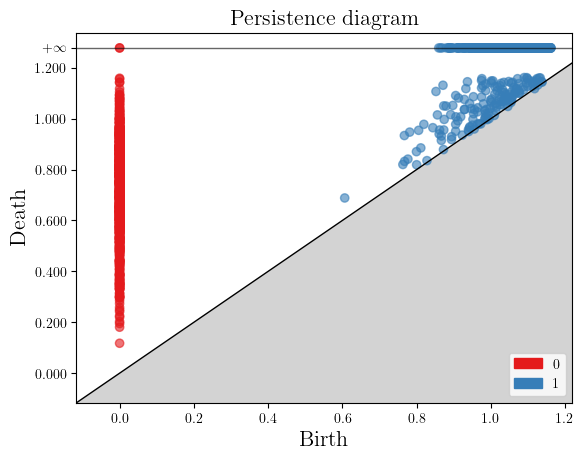

In [16]:
gudhi.plot_persistence_diagram(my_persistence, legend=True)

In [15]:
simplices = []
for d in range(D + 1):
    for facet, val in my_alpha_complex[d]:
        simplices.append(facet)

In [ ]:
Y_skel, Y = alphatools.compute_weighted_cech_graph(S, P, alpha / 2)

In [ ]:
L = laplacian(Y)

In [ ]:
#hl = HodgeLaplacians(simplices)

In [ ]:
#L1 = hl.getHodgeLaplacian(0)

In [ ]:
#L1

In [ ]:
# # Function to show the heat map
# ax = sns.heatmap( L1.todense() , cmap = 'autumn' )
  
# # Adding details to the plot
# plt.title( "2-D Heat Map" )
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')

# # Displaying the plot
# plt.show()

In [ ]:
# should be size (44850, 44850)

In [ ]:
extract_pairs = []
for dimension, pair in my_persistence:
    if dimension == 1:
        if pair[1] < np.inf:
            extract_pairs.append(pair)
        else: 
            new_pair = list(pair)
            new_pair[1] = alpha
            extract_pairs.append(new_pair)

In [ ]:
PI = PersistenceImage(bandwidth=0.1 * alpha, weight=lambda x: x[1]**2, resolution=[100,100])

In [ ]:
extract_pairs = np.array(extract_pairs)

In [ ]:
pi = PI.fit_transform([extract_pairs])

In [ ]:
# plt.imshow(np.flip(np.reshape(pi[0], [100,100]), 0))
# plt.title("Persistence Image")

In [ ]:
distance_distribution = squareform(pdist(S, 'euclidean'))
h = np.max(minimum_spanning_tree(distance_distribution))

In [ ]:
h

In [ ]:
num_landmarks = 50

chosen_indices = random.sample(range(n), num_landmarks)

chosen_landmarks = S[chosen_indices, :]

In [ ]:
assigned_voronoi_cells = np.argsort(cdist(S, chosen_landmarks), axis=1)

In [ ]:
def simplex_proportion(simplex): 
    
    fuzzy = 1
    
    simplex_set = set(simplex)
    
    count = 0
    for i in range(n): 
        subface = set(assigned_voronoi_cells[i,0:len(simplex) + 1])
        if simplex_set.issubset(subface):
            count += 1
    
    if count != 0:
        return 1/count
    else: 
        return np.inf

In [ ]:


def DiffRips(S, max_dimension = -1, max_radius = 2): 
    
    if max_dimension < 0: 
        max_dimension = len(S[0,:])
        
    VR_complex = defaultdict(list)
    X = SimplexTree()
    
    for i, s in enumerate(S): 
        value = simplex_proportion([i])
        VR_complex[0].append(([i], value))
        X.add_simplex([i], value)

    print("Evaluating Dimension", 1)
    
    Y = np.zeros((len(S), len(S)))
    adjacency = np.zeros((len(S), len(S)))
    with tqdm(total = len(S) ** 2) as pbar:
        for i in range(len(S)):
            curr_row = []
            for j in range(len(S)): 
                
                if i < j:
                    center_distance = simplex_proportion([i,j]) #voronoi_distance([i], [j])
                elif j < i:
                    center_distance = simplex_proportion([j,i])
                else: 
                    center_distance = simplex_proportion([i])
                    
                if center_distance < max_radius:
                    VR_complex[1].append(([i,j], center_distance))
                    Y[i,j] = center_distance
                    adjacency[i,j] = 1
                    X.add_simplex([i,j], center_distance)
                else:
                    Y[i,j] = math.inf

                pbar.update(1)
                
    print("\tNumber of Connected Components: ", connected_components(adjacency)[0])

    for curr_dim in range(2,max_dimension + 1):
        
        print("Estimating Number of Facets for dimension ", curr_dim, "Part 1:")
        
        facets_to_consider = VR_complex[curr_dim-1]
        visited_prev_words = SimplexTree()
        visited_prev_word_list = []
        
        if len(facets_to_consider) == 0:
            print("No facets to consider")
            break
        
        with tqdm(total = len(facets_to_consider)) as pbar:
            for facet, val in facets_to_consider:
                sub_facet = facet[:-1]
                if not visited_prev_words.contains_simplex(sub_facet):
                    visited_prev_words.add_simplex(sub_facet,0.0)
                    visited_prev_word_list.append(sub_facet)
                pbar.update(1)
                    
        print("Estimating Number of Facets for dimension ", curr_dim, "Part 2:")
        
        if len(visited_prev_word_list) == 0:
            print("No facets to consider")
            break
        
        Sigma = []
        with tqdm(total = len(visited_prev_word_list)) as pbar:
            for word in visited_prev_word_list:
                indices = X.simplex_leaves(word)
                for choose_pair in itertools.combinations(indices, r = 2):
                    suggested_word = word + list(choose_pair)
                    flag = True
                    for subsimplex in list(itertools.combinations(suggested_word, len(suggested_word) - 1)):
                        if not X.contains_simplex(subsimplex): 
                            flag = False
                            break

                    if flag:
                        Sigma.append(word + list(choose_pair))
                        
                pbar.update(1)
        
        print("Evaluating Dimension", curr_dim)
        
        if len(Sigma) == 0:
            print("No facets to consider")
            break
        
        with tqdm(total = len(Sigma)) as pbar:
            for simplex in Sigma:
                
                value = simplex_proportion(simplex)
                        
                if value != math.inf and value < max_radius:
                    VR_complex[curr_dim].append((simplex, value))
                    X.add_simplex(simplex, value)

                pbar.update(1)
    
    return VR_complex

In [ ]:
R = 1.0
abstract_cplx = DiffRips(chosen_landmarks, max_dimension = 3, max_radius = R)

In [ ]:
example2 = gudhi.SimplexTree()
filtration = []
for d in range(D + 1):
    for facet, val in abstract_cplx[d]:
        filtration.append((facet, val))
        example2.insert(facet, filtration=val)

In [ ]:
my_persistence = example2.persistence(homology_coeff_field = 2)

In [ ]:
extract_pairs = []
for dimension, pair in my_persistence:
    if dimension == 1:
        if pair[1] < np.inf:
            extract_pairs.append(pair)
        else: 
            new_pair = list(pair)
            new_pair[1] = alpha
            extract_pairs.append(new_pair)

extract_pairs = np.array(extract_pairs)

In [ ]:
PI = PersistenceImage(bandwidth=0.1 * alpha, weight=lambda x: x[1]**2, resolution=[100,100])

In [ ]:
pi = PI.fit_transform([extract_pairs])

In [ ]:
plt.imshow(np.flip(np.reshape(pi[0], [100,100]), 0))
plt.title("Persistence Image")